In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.simplefilter(action="ignore")

%matplotlib inline

## Load dataset

In [2]:
data = pd.read_stata("base_ifls2014.dta")
data.sample(4)

,level_0,hhid14,pid14,panel,tk01,tk02,tk03,tk04,tk01a,tk01b,...,sw01,sw03b,kk01,kk02a,kk02c,nonfood07,food07,total07,pce07,change
4521,5061,2851841,3.0,1:Panel,1:Working/trying to get work/helping to earn i...,NaN,NaN,NaN,1:Yes,3:No,...,3.0,1:Less adequate,3:Somewhat unhealthy,0.0,3:About the same,162814.178942,285388.753046,448202.931988,445269.857520,7.850648e+04
2987,3301,2370700,5.0,3:New,3:Attending school,1:Yes,NaN,NaN,1:Yes,1:Yes,...,3.0,2:Adequate,1:Very healthy,3.0,1:Much better now,136640.811882,166902.016418,303542.828300,303542.832417,2.501770e+06
3256,3590,1692400,4.0,1:Panel,1:Working/trying to get work/helping to earn i...,NaN,NaN,NaN,1:Yes,3:No,...,3.0,2:Adequate,2:Somewhat healthy,0.0,3:About the same,39707.528551,110516.372796,150223.901347,150223.905856,3.363146e+05
1625,1798,0511600,7.0,3:New,1:Working/trying to get work/helping to earn i...,NaN,NaN,NaN,1:Yes,3:No,...,4.0,2:Adequate,2:Somewhat healthy,3.0,3:About the same,139019.566690,296072.272625,435091.839315,431358.240927,2.123435e+05


In [3]:
#we have abundant categorical variable, either nominal or ordered
ok = data.select_dtypes("category")
before = data.copy()

## Shorten the values
*and little bit fill missing values.*

In [4]:
#binary data
for i in ok.columns:
    data[i] = data[i].astype("str").str.extract('(\d+)')
    if i in ["age"]:
        data[i] = data[i].astype("int")
    if (ok[i].nunique() <= 3) and (i !="tk25a9x"):
        #convert yes answer to 1, otherwise 0 (include nan, missing "9", nor dont know "8")
        data[i] = data[i].apply(lambda x: 0 if x != "1" else x).astype("int")  # in sex variable 1=male, 0=female

#make binary var base training duration, >0 week will be 1, otherwise 0
data["tk25a9x"] = data["tk25a9x"].apply(lambda x: 1 if x in ["2", "1"] else 0).astype("int") 

#replace "98":Dont know answe and "99":Missing to np.nan
data.replace({"99": np.nan, "98": np.nan, "9998":np.nan}, inplace=True)

In [5]:
#education variable
# first thing is aggregation to smaller group

def educagg(data):
    one = ["2", "11", "90", "72"] #primary school
    two = ["3", "4", "12", "73"] #junior high school
    three = ["5", "6", "15", "74"] #high school
    four = ["60", "61", "62", "63", "13"] #college
    if data in one:
        return 1
    elif data in two:
        return 2
    elif data in three:
        return 3
    elif data in four:
        return 4
    else:
        return np.nan
    
data["dl06"] = data["dl06"].apply(lambda x: educagg(x)) #aggregation
data.sample(8)

,level_0,hhid14,pid14,panel,tk01,tk02,tk03,tk04,tk01a,tk01b,...,sw01,sw03b,kk01,kk02a,kk02c,nonfood07,food07,total07,pce07,change
4590,5158,2792011,4.0,0,3,1,0,0,1,1,...,4,2,2,0,2,429433.090508,303964.932765,733398.023273,733397.945715,-160748.449950
5198,5913,3090131,4.0,0,3,1,0,0,1,1,...,3,2,2,15,2,81996.192441,249510.873899,331507.066340,329433.576305,746830.758034
1161,1229,0411600,5.0,0,1,0,0,0,1,0,...,3,2,1,1,2,150827.964144,200392.797347,351220.761490,351220.752798,273505.434218
1888,2082,1420900,10.0,0,3,0,0,0,0,1,...,4,3,2,0,3,341771.820781,315157.748423,656929.569203,650620.386435,-213004.590070
4910,5536,2980641,6.0,0,95,0,0,0,0,0,...,3,2,2,0,3,97051.345388,147807.607929,244858.953317,224831.326895,378972.918830
3585,3933,2071000,7.0,0,3,0,0,0,0,1,...,4,2,1,0,2,55236.107631,46050.201918,101286.309549,101073.345259,273575.845413
2575,2876,1080441,2.0,1,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,435392.078004,537747.040434,973139.118438,973139.123397,-517526.041147
1099,1161,1900931,3.0,0,3,0,0,0,0,1,...,3,2,2,0,1,485013.274657,199162.667400,684175.942056,596348.916855,142309.262548


In [6]:
for i in ok.columns:
    if (ok[i].nunique() > 3) and (ok[i].isnull().sum() >0):
        print (i, data[i].unique())

tk01 ['3' '4' '1' '7' '2' '95' nan]
dl06 [ 2.  3.  4.  1. nan]
dl05a ['7' '6' nan '5' '9' '8' '4' '10' '12' '2' '19' '15']
dl16c2 [nan '5' '4' '3' '6' '7' '8' '9' '2' '10']
dl11d ['6' nan '3' '1' '8']
dl11f [nan '2014' '2001' '2012' '2007' '2010' '2009' '2013' '2008' '2011' '2015'
 '2003' '2000' '2005' '2006' '2004' '1998' '2002' '1999']
sw00 ['2' '3' nan '4' '5' '1']
sw01 ['3' '2' nan '1' '4' '6' '5' '8']
sw03b ['1' '2' '3' nan '8']
kk01 ['3' '1' '4' '2' nan]
kk02a ['2' '0' '3' '1' nan '14' '7' '5' '4' '9' '28' '10' '21' '11' '12' '8' '6'
 '15' '20']
kk02c ['1' '3' '2' '4' '5' nan]


In [7]:
# convert dont know answer to NaN
for i in ["dl11d", "sw01", "sw03b"]:
    data[i] = data[i].apply(lambda x: np.nan if x == "8" else x)

## Handle Missing Values
---
At first to understand, it doesn’t exist a good way to deal with missing data. Different solutions exist for data imputation which however depends on the kind of problem. Many data are missing because several reason such as the response was out of range, questionable, or not applicable; or respondent refused to answer or didn’t know. So, missing data have several types. First step, we should distinguish between missing at random and not random because of maybe interviewer error. Several methode that can be used for single Imputation, like listwise deletion, central tendency (mean/median/mode), Hot-Cold Deck, nor Regression. ***However, values found in single imputation might be biased by the specific values in the current data set, and not represent the total values of the full population***. This problem can be reduuce with multiple imputation. It metode has a lot of advantages over traditional single imputation methods. Multiple Imputation is an imputation method that works with the assumption that the missing data are missing at Random. The algorithm works by running multiple models and each missing value is modeled conditionally depending on the observed values.

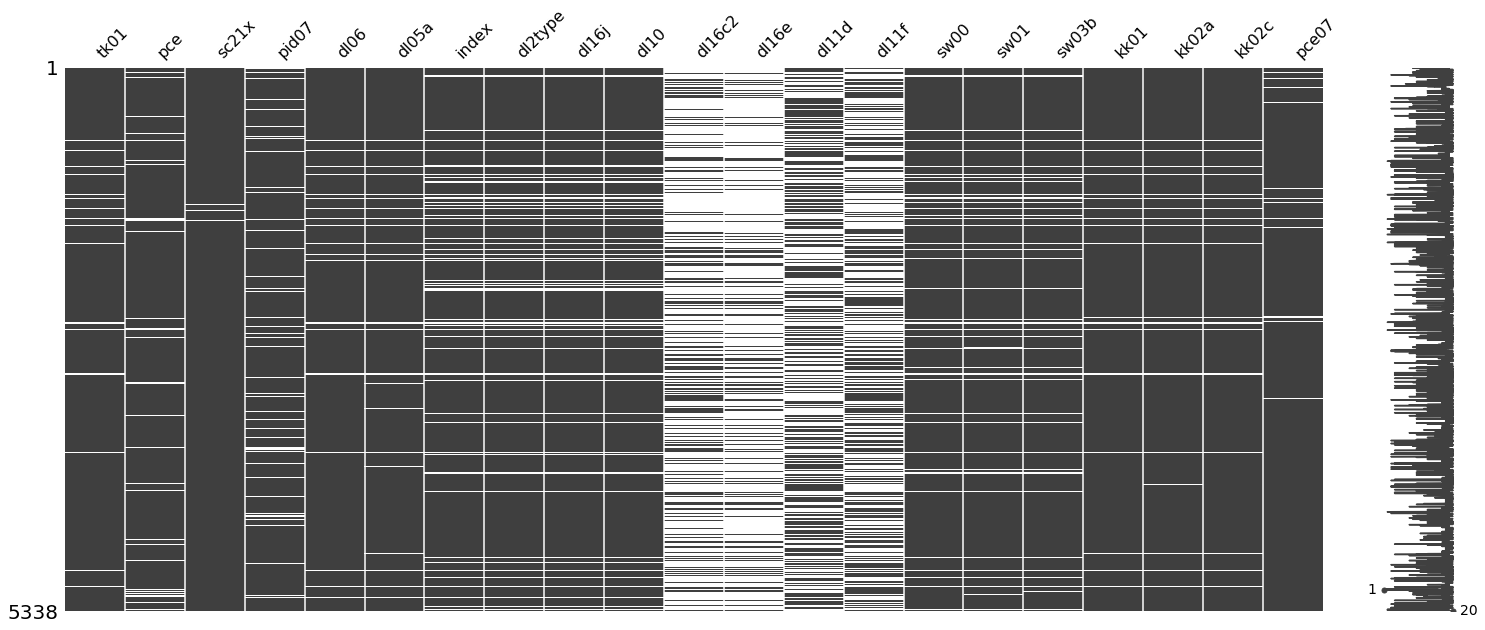

In [8]:
missingdata = data.columns[data.isnull().any()].tolist()
msno.matrix(data[missingdata])

|variable|description|
|---|---|
tk01| main acivity
dl06| highest education attainment
dl05a| first age entered elementary school
dl11d| gratuated?
sw00| overall subjective welfare right now
sw01| subjective economic status
sw03b| subjective household condition
dl11f| year of graduated OR dropout
dl16c2| number of subjects in the EBTANAS / UAN / UN exam
sc21x| migration history
kk01| subjective overall health condition
kk02a| days missed at primary activity last month
kk02c| Compared health 12 months ago
ar02b| relation with Head Household
dl11f| year of graduated OR dropout
sc21x| migration history
kk01| subjective overall health condition
kk02a| days missed at primary activity last month
kk02c| Compared health 12 months ago

In [9]:
#categorical data imputed with KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [10]:
#create new a knn model
knn = KNeighborsClassifier(weights='distance')
param_grid = {"n_neighbors": np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

In [11]:
#fit model to data
for i in list(data[missingdata].select_dtypes("object").columns):
    df = data[data[i].notnull()]
    df1 = data[data[i].isnull()]
    X = df[["food", "nonfood",  "age", "sex", "ar02b_14", "kabid"]] #independent variable to predict
    y = df[i]
    knn_gscv.fit(X, y)
    X_test = df1[["food", "nonfood",  "age", "sex", "ar02b_14", "kabid"]]
    df1[i] = knn_gscv.predict(X_test)
    data = pd.concat([df, df1])
    print ("R-squared of ", i, "is", round(knn_gscv.best_score_, 2), "with n_neighbors equal to", knn_gscv.best_params_["n_neighbors"])

R-squared of  tk01 is 0.43 with n_neighbors equal to 23
R-squared of  sc21x is 0.72 with n_neighbors equal to 24
R-squared of  dl05a is 0.47 with n_neighbors equal to 21
R-squared of  dl16c2 is 0.38 with n_neighbors equal to 15
R-squared of  dl11d is 0.84 with n_neighbors equal to 22
R-squared of  dl11f is 0.14 with n_neighbors equal to 18
R-squared of  sw00 is 0.41 with n_neighbors equal to 12
R-squared of  sw01 is 0.44 with n_neighbors equal to 24
R-squared of  sw03b is 0.51 with n_neighbors equal to 24
R-squared of  kk01 is 0.56 with n_neighbors equal to 24
R-squared of  kk02a is 0.54 with n_neighbors equal to 24
R-squared of  kk02c is 0.41 with n_neighbors equal to 24


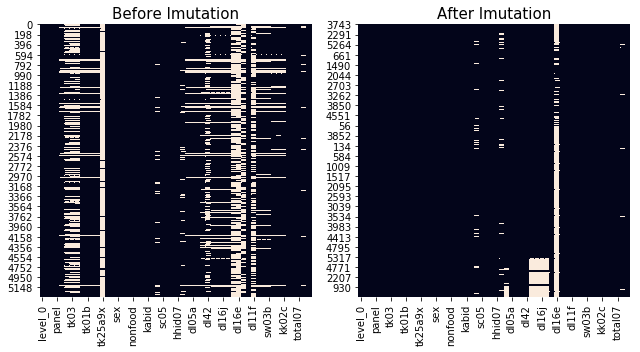

In [12]:
plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
sns.heatmap(before.isnull(), cbar=False)
plt.title("Before Imutation", size=15)
plt.subplot(1,2,2)
sns.heatmap(data.isnull(), cbar=False)
plt.title("After Imutation", size=15)
plt.tight_layout()

In [13]:
j = data.isnull().sum()/len(data)
j[j>0.01]

pce        0.062758
pid07      0.090483
dl06       0.050955
index      0.124766
dl2type    0.124766
dl16j      0.124766
dl10       0.124766
dl16e      0.785500
pce07      0.023230
dtype: float64

## Define NEET variabel
**We could operational NEET in two ways**

In [14]:
##### Based on main activity in one week -- tk01
et= data[((data["tk01"] == "1") | (data["tk01"] == "3") | (data["tk25a9x"] == 1))]
et["NEET"] = 0
neet = data[~((data["tk01"] == "1") | (data["tk01"] == "3") | (data["tk25a9x"] == 1))]
neet["NEET"] = 1
data = pd.concat([et, neet], axis=0)

#Second one, based on a strict list of activity ever do in last week -- tk01a-d, tk02,tk03, tk04 
data["NEET(1)"] = data[["tk02","tk03","tk04","tk01a","tk01b", "tk25a9x"]].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
data

,level_0,hhid14,pid14,panel,tk01,tk02,tk03,tk04,tk01a,tk01b,...,kk01,kk02a,kk02c,nonfood07,food07,total07,pce07,change,NEET,NEET(1)
16,28,0022942,3.0,0,1,0,0,0,1,0,...,2,0,2,62418.011894,145232.972578,207650.984472,207650.973562,432737.418052,0,0
20,32,0030200,8.0,0,1,0,0,0,1,0,...,3,1,2,152304.176717,123998.119525,276302.296242,231710.458455,-33251.590730,0,0
33,45,0031300,7.0,0,1,0,0,0,1,0,...,3,0,3,80170.115526,330294.940967,410465.056494,410465.040625,46308.008200,0,0
52,65,0032800,5.0,0,1,0,0,0,1,0,...,2,0,3,449430.838993,397923.622572,847354.461565,688100.403072,-465628.172392,0,0
64,79,0040200,9.0,0,1,0,0,0,1,0,...,2,0,3,136813.330879,0.000000,136813.330879,NaN,703997.681750,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5121,5829,3060900,12.0,0,4,0,0,0,0,0,...,3,0,2,91525.224872,0.000000,91525.224872,NaN,367405.388435,1,1
5122,5831,3060900,13.0,0,4,0,0,0,0,0,...,3,0,2,91525.224872,0.000000,91525.224872,NaN,367405.388435,1,1
5124,5835,3060900,16.0,0,4,0,0,0,0,0,...,3,0,2,91525.224872,0.000000,91525.224872,NaN,367405.388435,1,1
5266,5983,3111800,12.0,0,4,0,0,0,0,0,...,2,0,1,576092.094446,178480.761782,754572.856228,752205.777921,-437465.015507,1,1


In [15]:
# make relative frequn
data["total_zscore"] = (data["total"] - data["total"].mean())/data["total"].std(ddof=0)
data["desil"] =pd.qcut(data.total, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

In [16]:
a = data.loc[(data['NEET']== 1) & (data["tk01"] == "95"),'change'].rename("NEET")
b = data.loc[(data['NEET']== 0),'change'].rename("EET")

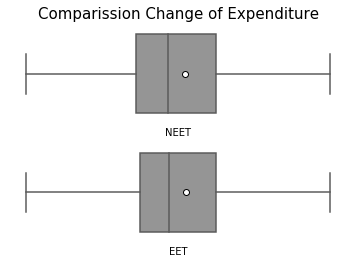

In [17]:
hei = ["r", a, b]
for i in range(1, 3, 1):
    plt.title("Comparission Change of Expenditure", size=15)
    plt.subplot(2,1,i)
    sns.boxplot(hei[i], showfliers = False, showmeans=True, 
                palette="Greys", meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})
    #plt.xlim(-1.5, 2)
    plt.xticks([])
    plt.yticks([])
    sns.despine(left = True, bottom = True)

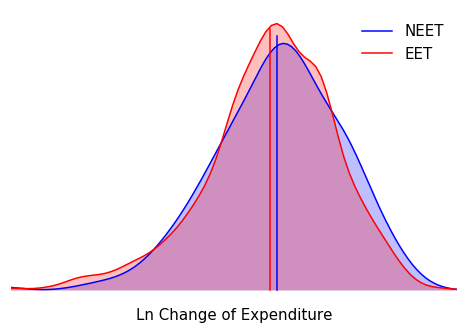

In [18]:
#with plt.xkcd():
plt.figure(figsize=(8, 5.4))
sns.kdeplot(np.log(a), color="b", shade=True, kernel='gau', Label='NEET')
sns.kdeplot(np.log(b), color="r", shade=True, kernel='gau', Label='EET')
plt.plot([np.log(a).mean(),np.log(a).mean()], [0.36, 0], c="b")
plt.plot([np.log(b).mean() ,np.log(b).mean()], [0.37, 0], c="r")
sns.despine(left = True, bottom = True)
plt.xlabel("Ln Change of Expenditure", size=15)
plt.yticks([])
plt.xticks([])
plt.legend(frameon=False,prop={'size': 15})
#plt.ylim(0, 0.65)
plt.xlim(8, 16)
plt.show()